# setting

## path

In [23]:
import sys, os
home_path = os.path.expanduser("~")
sys.path.append(home_path + '/Desktop/Credit_Comp/py/models/')
sys.path.append(home_path + '/Desktop/Credit_Comp/py/')
sys.path.append(home_path + '/.pyenv/versions/3.6.5/lib/python3.6/site-packages')
sys.path.append(home_path + '/.pyenv/versions/3.6.5/lib/python3.6/site-packages/xgboost-0.81-py3.6.egg')

## module

使用するモジュールをimport

In [24]:
import numpy as np # linear algebra
import pandas as pd # data processing
import pandas_profiling as pdp
import base # basic processed code
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import *
%matplotlib inline

In [25]:
# moduleの再読み込み(作業中に更新した内容をここで更新できる)
import importlib
importlib.reload(base)

<module 'base' from '/Users/takuto/Desktop/Credit_Comp/py/base.py'>

In [26]:
# for instance
Process = base.Process()
Applicate = base.Applicate()

## read data

In [27]:
train, test, target = Process.read_data1()

27000 observations and 24 features in train set.
3000 observations and 23 features in test set.


# eda

In [6]:
# 欠損値の確認
Applicate.missing_value(train)

,y,X23,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X1
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
# 簡単なレポート作成
profile = pdp.ProfileReport(train)
file_name = home_path + '/Desktop/Credit_Comp/output/report/train_data_profile.html'
profile.to_file(outputfile = file_name)

# Detail

## クレジット金額と支払い履行の関係性

少額を踏み倒している?

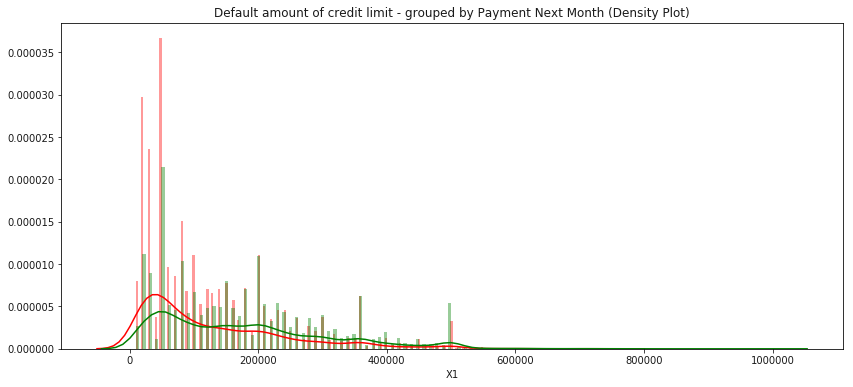

In [8]:
class_0 = train.loc[train['y'] == 0]['X1']
class_1 = train.loc[train['y'] == 1]['X1']
plt.figure(figsize = (14,6))
plt.title('Default amount of credit limit - grouped by Payment Next Month (Density Plot)')
sns.set_color_codes("pastel")
sns.distplot(class_1,kde=True,bins=200, color="red")
sns.distplot(class_0,kde=True,bins=200, color="green")
plt.show()

## 年齢と支払い履行の関係性

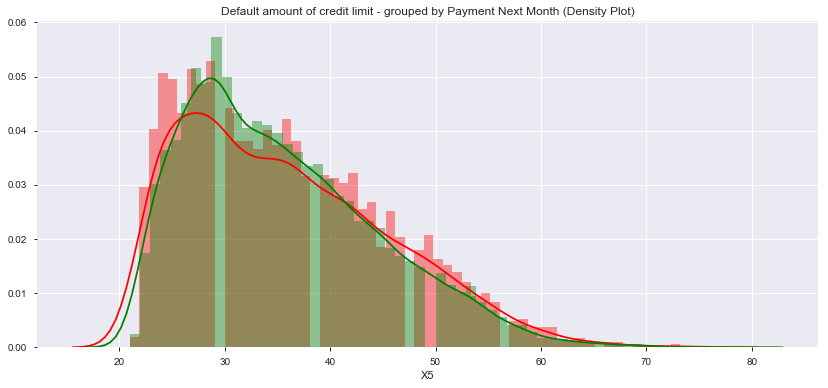

In [108]:
class_0 = train.loc[train['y'] == 0]['X5']
class_1 = train.loc[train['y'] == 1]['X5']
plt.figure(figsize = (14,6))
plt.title('Default amount of credit limit - grouped by Payment Next Month (Density Plot)')
sns.set_color_codes("pastel")
sns.distplot(class_1,kde=True,bins=60, color="red")
sns.distplot(class_0,kde=True,bins=60, color="green")
plt.show()

## カテゴリカル変数のクロス集計 

In [111]:
print("性別（1=男性, 2=女性)")
print(pd.crosstab(index=train["X2"],columns=train["y"]))
print("教育（1=大学院, 2=大学, 3=高校, 0,4,5,6=その他）")
print(pd.crosstab(index=train["X3"],columns=train["y"]))
print("婚姻状況（1=既婚, 2=単身, 3=離婚, 0=その他）")
print(pd.crosstab(index=train["X4"],columns=train["y"]))

性別（1=男性, 2=女性)
y       0     1
X2             
1    8126  2591
2   12880  3403
教育（1=大学院, 2=大学, 3=高校, 0,4,5,6=その他）
y      0     1
X3            
0     12     0
1   7671  1834
2   9633  3013
3   3317  1117
4    105     6
5    226    18
6     42     6
婚姻状況（1=既婚, 2=単身, 3=離婚, 0=その他）
y       0     1
X4             
0      42     4
1    9402  2904
2   11348  3010
3     214    76


# Feature Correlation

## 支払い記録の相関

1ヶ月ごとに遅れていくので, 相関が生まれやすい

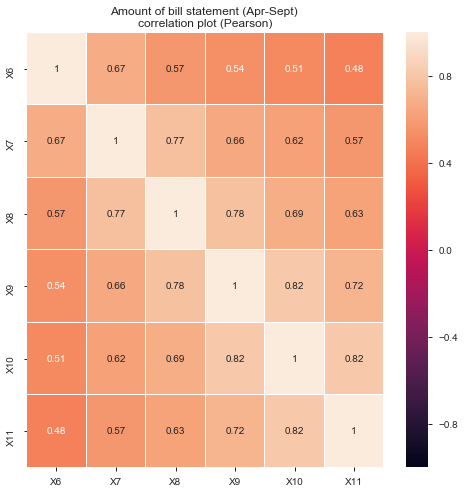

In [117]:
var = ["X6","X7","X8","X9","X10","X11"]
plt.figure(figsize = (8,8))
plt.title('Amount of bill statement (Apr-Sept) \ncorrelation plot (Pearson)')
corr = train[var].corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,vmin=-1, vmax=1,annot=True)
plt.show()

## 請求明細書の相関

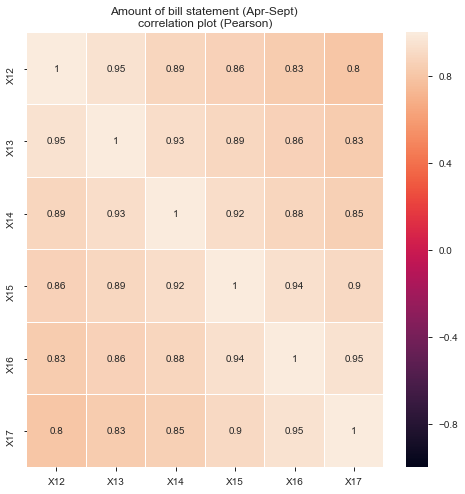

In [118]:
var = ["X12","X13","X14","X15","X16","X17"]
plt.figure(figsize = (8,8))
plt.title('Amount of bill statement (Apr-Sept) \ncorrelation plot (Pearson)')
corr = train[var].corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,vmin=-1, vmax=1,annot=True)
plt.show()

# Algorithm Selection

複数のモデル等を適用してみて, 今後の方針を考える.

## Decition tree

In [7]:
# module
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydotplus 
from IPython.display import Image
from sklearn.externals.six import StringIO
# execute model
clf = DecisionTreeClassifier(max_depth = 3)
clf = clf.fit(train.drop("y",axis=1), train["y"])
# predict value
predict = clf.predict(test)
predict
# sample submit
Process.submit(predict,tech="simple_decision_tree")

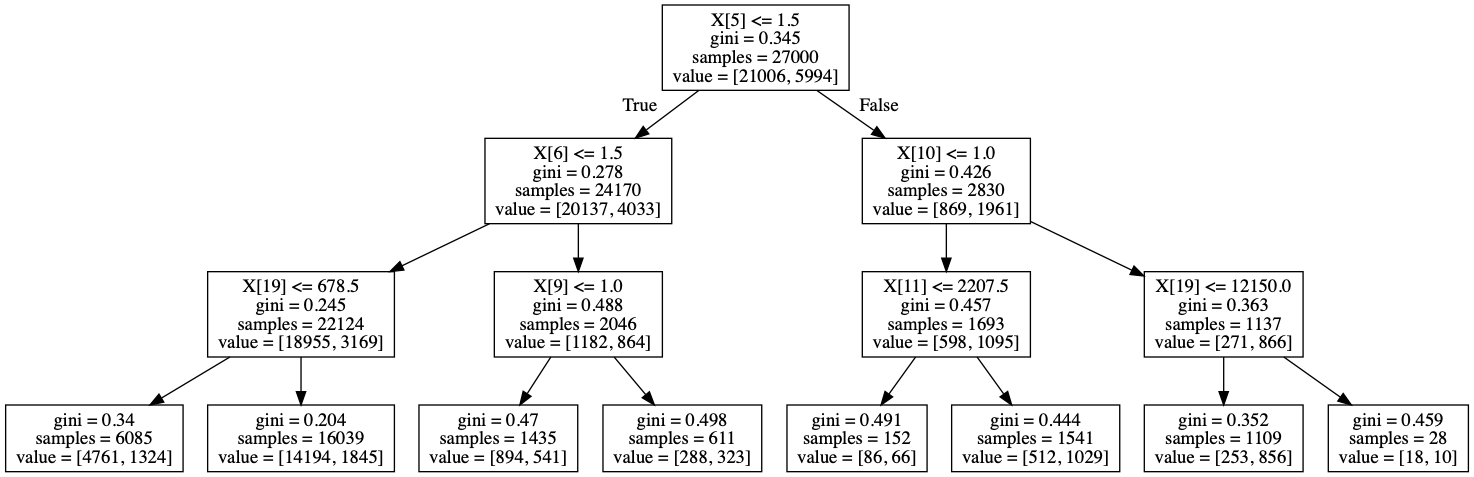

In [8]:
# treeの可視化
dot_data = StringIO()
export_graphviz(clf,out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
# pdfに保存
Image(graph.create_png())

## some models

In [62]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

In [63]:
# classifier list for the normal training set
clf_list = [DecisionTreeClassifier(max_depth = 3, class_weight = "balanced"), 
            RandomForestClassifier(n_estimators = 100, class_weight = "balanced"), 
            AdaBoostClassifier(DecisionTreeClassifier(max_depth = 3, 
                                                      class_weight = "balanced"),
                               n_estimators = 100), 
            GradientBoostingClassifier(), 
            XGBClassifier()
           ]

In [64]:
# select features
features = test.columns.values

In [65]:
# use Kfold to evaluate the normal training set
kf = KFold(n_splits=5,random_state=831,shuffle=True)

# add list
mdl = []
fold = []
scr = []

# validation (これはバリデーションしていることになるのか??)
for i,(trn_index, val_index) in enumerate(kf.split(train)):
    training = train.iloc[trn_index][features]
    valid = train.iloc[val_index][features]
    trn_target = train.iloc[trn_index]['y']
    val_target = train.iloc[val_index]['y']
    print("fold n°{}".format(i+1))
    for clf in clf_list:
        model = clf.__class__.__name__
        clf.fit(training,trn_target) 
        pred = clf.predict(valid)
        score = f1_score(y_true = val_target, y_pred = pred)
        fold.append(i+1)
        scr.append(score)
        mdl.append(model)
        print(model)

fold n°1
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBClassifier
fold n°2
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBClassifier
fold n°3
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBClassifier
fold n°4
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBClassifier
fold n°5
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
XGBClassifier


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [68]:
# Lightgbm classifier
# use Kfold to evaluate the normal training set
kf = KFold(n_splits=5,random_state=831,shuffle=True)
param = Process.open_parameter(file_name = 'lgb_classifer_param')
feature_importance = pd.DataFrame()
# validation
for i,(trn_index, val_index) in enumerate(kf.split(train)):
    print("fold n°{}".format(i+1))
    # data set
    trn_data = lgb.Dataset(train.iloc[trn_index][features], label=train.iloc[trn_index]['y'])
    val_data = lgb.Dataset(train.iloc[val_index][features], label=train.iloc[val_index]['y'])
    # model
    model = lgb.train(param, 
                      trn_data, 
                      num_boost_round=10000, 
                      valid_sets = [trn_data, val_data],
                      verbose_eval=100, 
                      early_stopping_rounds=200)
    # model importance 
    fold_importance = pd.DataFrame({'feature': features, 
                                       'importance': model.feature_importance(),
                                       'fold': i + 1})
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    # validation predict
    pred = model.predict(train.iloc[val_index][features], 
                         num_iteration=model.best_iteration)
    pred = np.round(pred).astype(int)
    # score
    score = f1_score(y_true = train.iloc[val_index]['y'], y_pred = pred)
    fold.append(i+1)
    scr.append(score)
    mdl.append("Lightgbm Classifier")

fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.156944	valid_1's binary_error: 0.177037
[200]	training's binary_error: 0.129769	valid_1's binary_error: 0.178519
Early stopping, best iteration is:
[56]	training's binary_error: 0.166204	valid_1's binary_error: 0.175185
fold n°2
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.156065	valid_1's binary_error: 0.177222
[200]	training's binary_error: 0.12963	valid_1's binary_error: 0.179815
Early stopping, best iteration is:
[25]	training's binary_error: 0.174815	valid_1's binary_error: 0.17463
fold n°3
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.156157	valid_1's binary_error: 0.180556
[200]	training's binary_error: 0.131528	valid_1's binary_error: 0.185556
Early stopping, best iteration is:
[19]	training's binary_error: 0.175833	valid_1's binary_error: 0.177037
fold n°4
Training until val

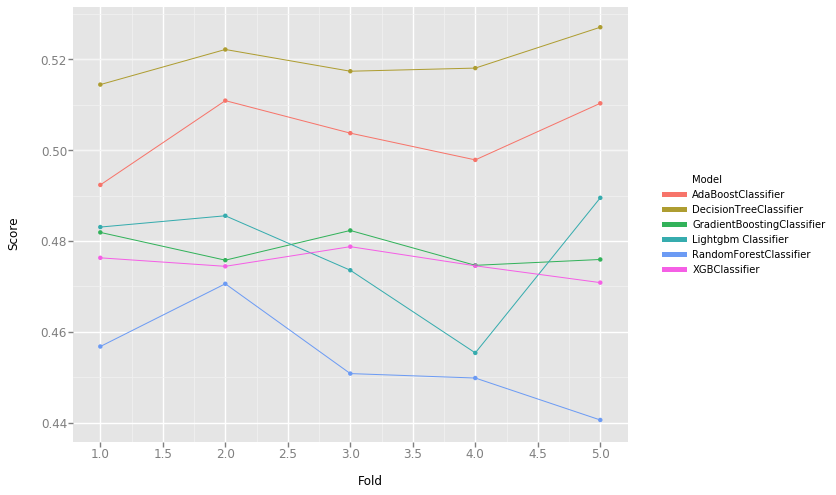

<ggplot: (-9223372036563326197)>


In [67]:
#create a small df with the scores
performance = pd.DataFrame({'Model': mdl, 'Score':scr,'Fold':fold})
g_normal = ggplot(performance,aes(x='Fold',y='Score',group = 'Model',color = 'Model')) + geom_point() + geom_line()
print(g_normal)

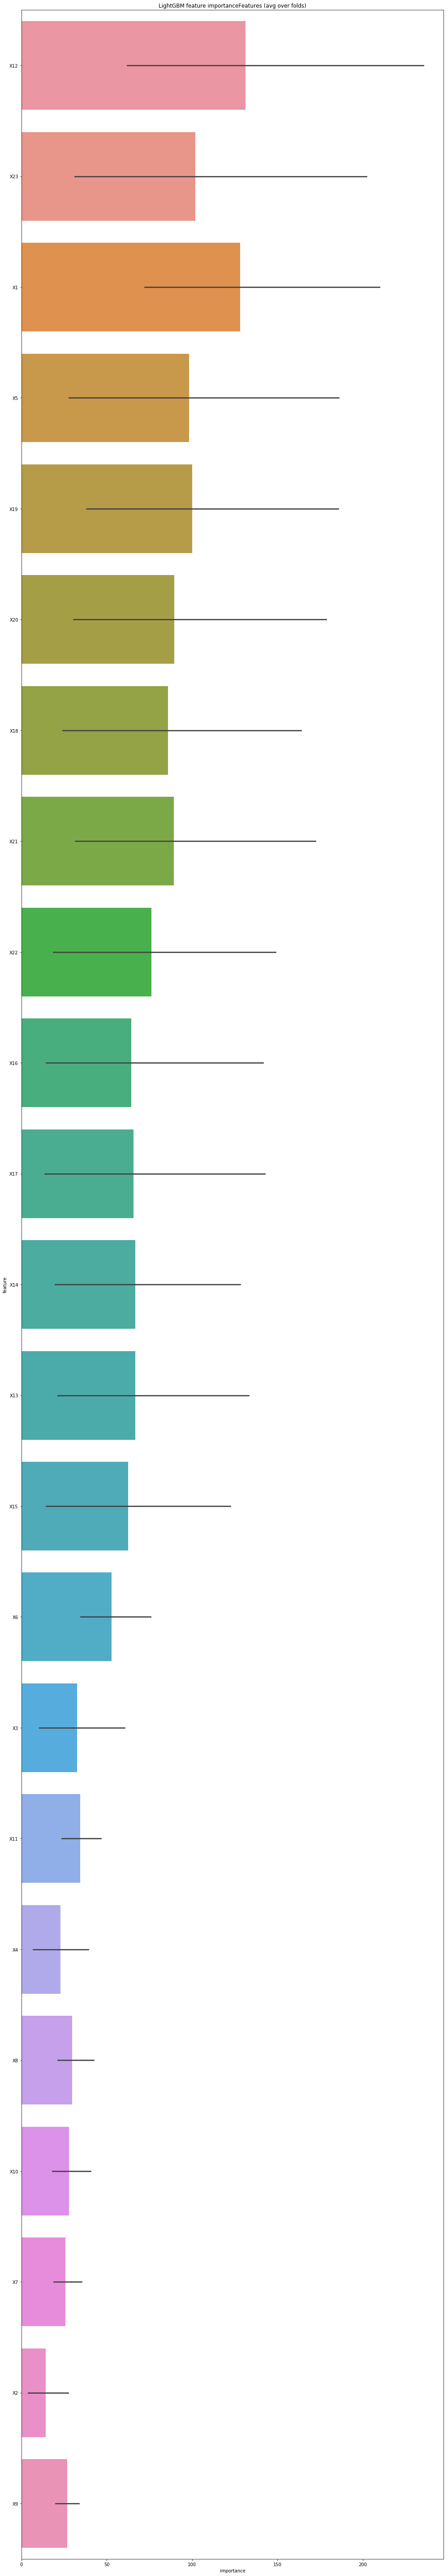

In [70]:
# create lightgbm importance display
Process.display_importances(feature_importance, title="LightGBM feature importance")